In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the DataFrame from the pickle file
df = pd.read_pickle("/content/drive/MyDrive/CSE 280/WattBuyData1999_2024.pkl")

In [ ]:
# filter to have default rates only
df = df[df['utility_rate_type'] == 'default rate'].copy()

# Convert created_at to datetime and extract year and month
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month

# Filter data from 2014 to 2024
filtered_df = df[(df['year'] >= 2014) & (df['year'] <= 2024)]

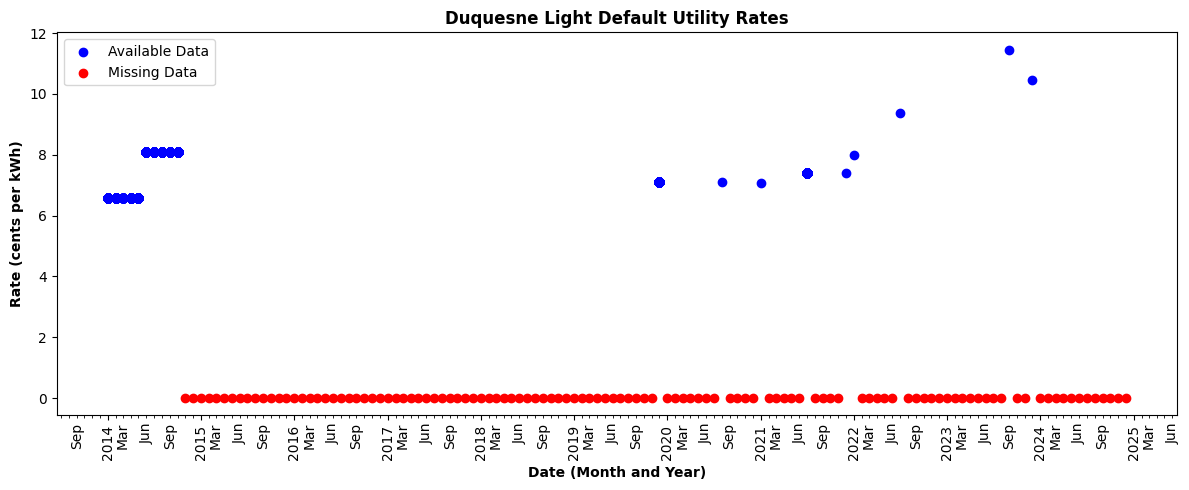

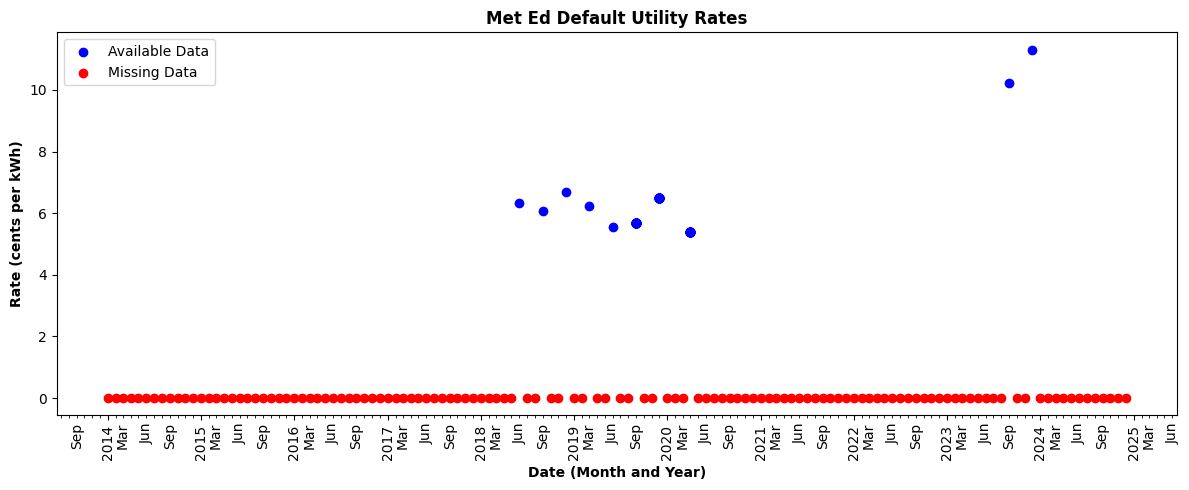

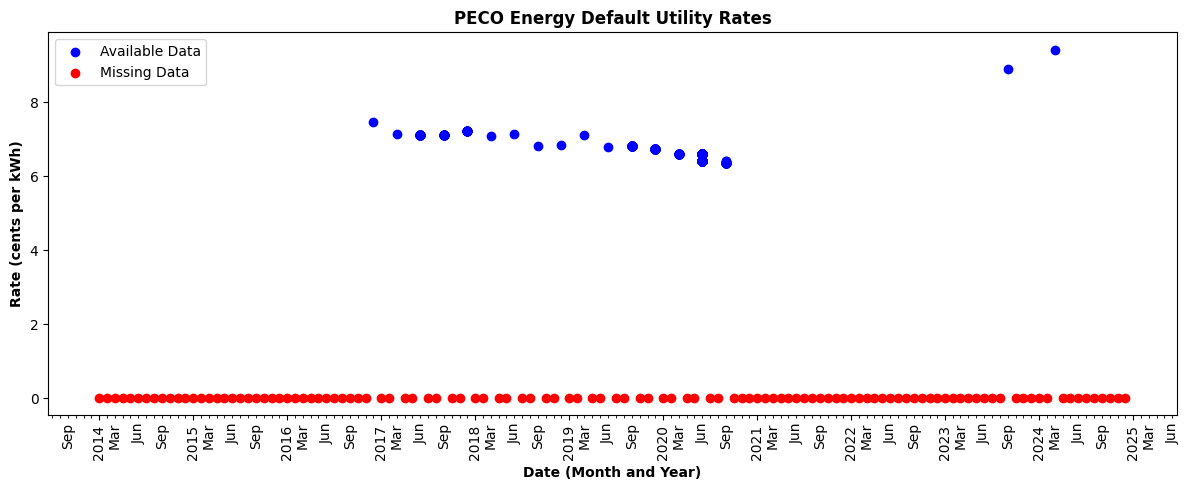

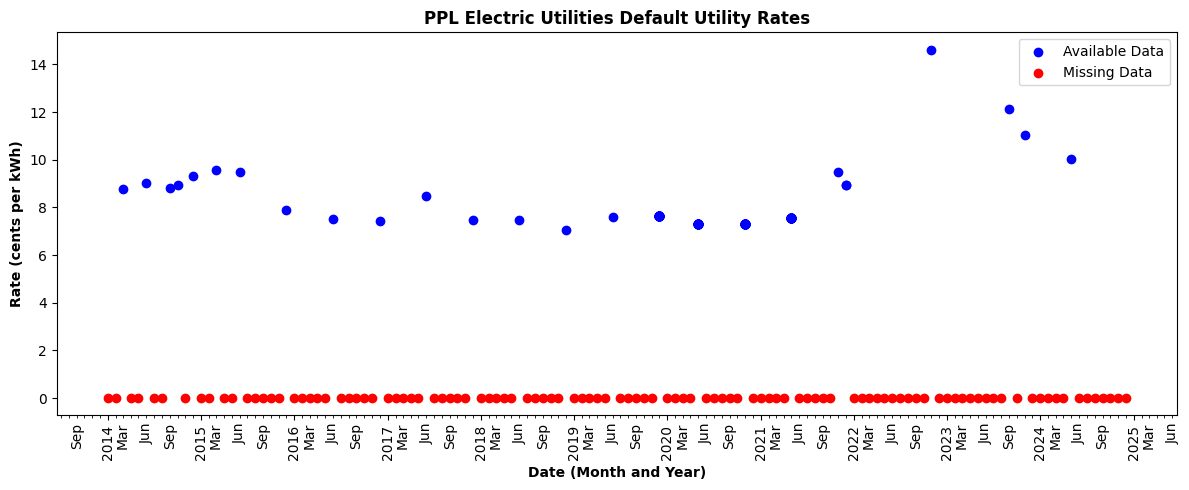

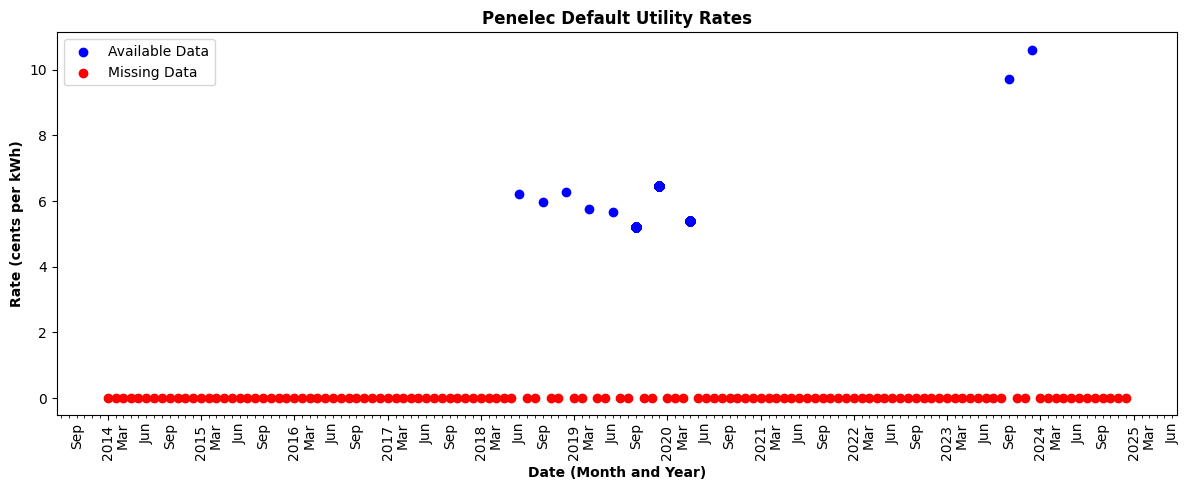

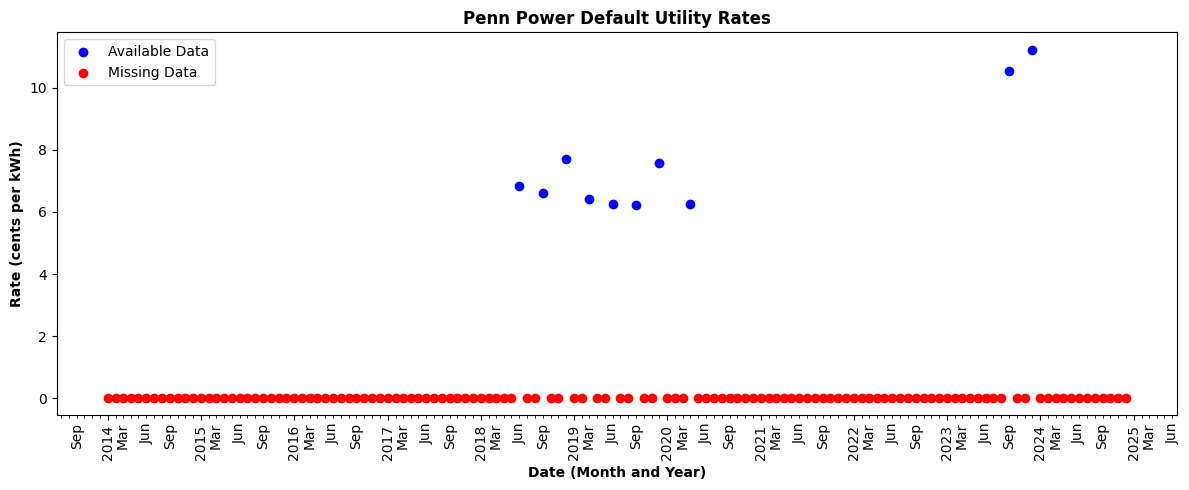

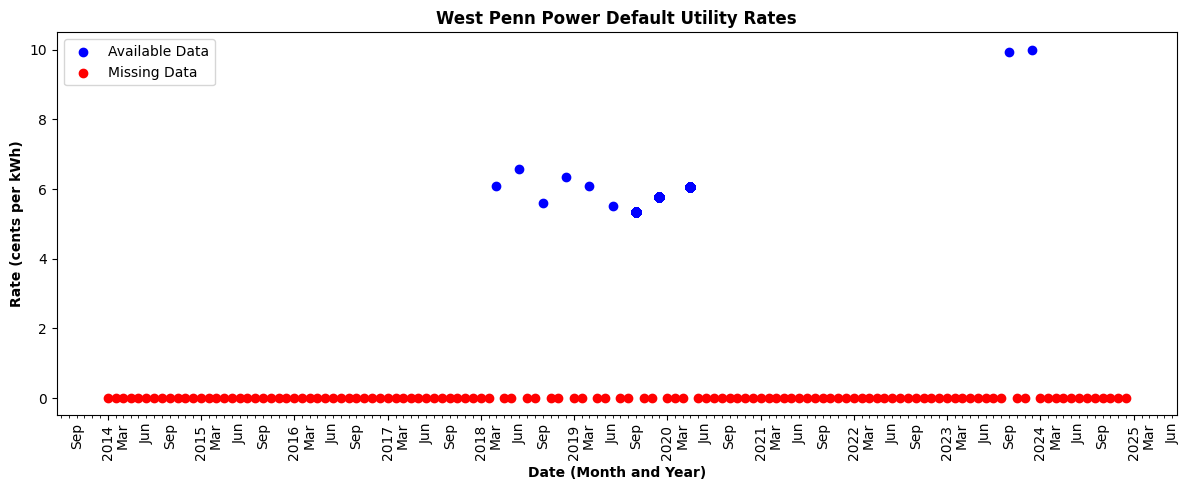

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Create a complete DataFrame of all months from 2014 to 2024 for each utility
all_months = pd.date_range(start='2014-01-01', end='2024-12-31', freq='MS')
all_utils = filtered_df['utility_name'].unique()
mux = pd.MultiIndex.from_product([all_utils, all_months], names=['utility_name', 'date'])
complete_df = pd.DataFrame(index=mux).reset_index()

# Merge with available data
available_data = filtered_df[['utility_name', 'created_at', 'utility_rate_amount']].dropna(subset=['utility_rate_amount'])
available_data['date'] = available_data['created_at'].dt.to_period('M').dt.to_timestamp()
merged_data = complete_df.merge(available_data, on=['utility_name', 'date'], how='left')

# Mark the missing data points for visualization
merged_data['is_missing'] = merged_data['utility_rate_amount'].isna()

# Custom function for x-axis labeling
def custom_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.month in [3, 6, 9]:
        return date.strftime('%b')
    else:
        return ''

# Plot the trends for each utility
for utility_name, group in merged_data.groupby('utility_name'):

    # Filter out the missing data for specific markers
    missing_data = group[group['is_missing']]
    available_data = group[~group['is_missing']]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(available_data['date'], available_data['utility_rate_amount'], label='Available Data', marker='o', color='blue')
    ax.scatter(missing_data['date'], [0] * len(missing_data), color='red', marker='o', label='Missing Data')

    # Set major and minor locators and formatters for x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

    # Rotate and align the labels
    plt.setp(ax.get_xticklabels(which='both'), rotation=90)

    # Set labels and title
    ax.set_xlabel('Date (Month and Year)',fontweight='bold')
    ax.set_ylabel('Rate (cents per kWh)',fontweight='bold')
    ax.set_title(f'{utility_name} Default Utility Rates', fontweight='bold')

    # Add a legend
    ax.legend()

    plt.tight_layout()
    # Save the plot as an image
    plot_filename = f"{utility_name}_default_rate_trend_and_plan_rates.png"
    plt.savefig(plot_filename)
    plt.show()

In [ ]:
# Extract missing data entries
missing_entries = merged_data[merged_data['is_missing']].copy()

# Prepare the DataFrame to list only utility name, year, and month of missing data
missing_entries['year'] = missing_entries['date'].dt.year
missing_entries['month'] = missing_entries['date'].dt.month

# Create a clean DataFrame showing only necessary columns
missing_data_formatted = missing_entries[['utility_name', 'year', 'month']]

# Optionally, sort by utility name and date for better readability
missing_data_formatted = missing_data_formatted.sort_values(by=['utility_name', 'year', 'month'])

# Reset index for a clean presentation
missing_data_formatted.reset_index(drop=True, inplace=True)

In [ ]:
missing_data_formatted.rename(columns={'utility_name': 'Utility_Provider_Name', 'year': 'Year', 'month': 'Month'}, inplace=True)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
# Function to paginate DataFrame across multiple pages, with a title and bold headers
def paginate_dataframe(df, pdf, rows_per_page=25):
    total_rows = len(df)
    pages = (total_rows // rows_per_page) + 1  # Total number of pages

    for page in range(pages):
        start_row = page * rows_per_page
        end_row = min(start_row + rows_per_page, total_rows)

        # Get the slice of DataFrame for this page
        df_slice = df.iloc[start_row:end_row]

        # Create a figure for the table
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('tight')
        ax.axis('off')

        # Add the title above the table (only on the first page)
        if page == 0:
            fig.suptitle('Table 1: Missing Utility Provider Data (2014-2024)', fontsize=14, fontweight='bold')

        # Create the table on the figure, bolding the header
        table = ax.table(cellText=df_slice.values, colLabels=df.columns, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

        # Bold the header
        for key, cell in table.get_celld().items():
            if key[0] == 0:  # This is the header row
                cell.set_text_props(weight='bold')

        # Save the page in the PDF
        pdf.savefig(fig)
        plt.close()


In [ ]:
# Custom function for x-axis labeling
def custom_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.month in [3, 6, 9]:  # Highlight March, June, September
        return date.strftime('%b')
    return ''

# Setup PDF file
with PdfPages('Missing_Default_Utility_Provider_Rates.pdf') as pdf:
    # Plot the trends for each utility
    for utility_name, group in merged_data.groupby('utility_name'):
        # Filter out the missing data for specific markers
        missing_data = group[group['is_missing']]
        available_data = group[~group['is_missing']]

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.scatter(available_data['date'], available_data['utility_rate_amount'], label='Available Data', marker='o', color='blue')
        ax.scatter(missing_data['date'], [0] * len(missing_data), color='red', marker='o', label='Missing Data')

        # Set major and minor locators and formatters for x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

        # Rotate and align the labels
        plt.setp(ax.get_xticklabels(which='both'), rotation=90)

        # Set labels and title
        ax.set_xlabel('Date (Month and Year)',fontweight='bold')
        ax.set_ylabel('Rate (cents per kWh)',fontweight='bold')
        ax.set_title(f'{utility_name} Default Utility Rates', fontweight='bold')

        # Add a legend
        ax.legend()

         # Adjust layout to prevent cutoff
        plt.tight_layout()

        # Save the current figure to the PDF
        pdf.savefig(fig)
        plt.close()

    # After the charts, paginate the missing data table
    paginate_dataframe(missing_data_formatted, pdf, rows_per_page=25)

print("PDF generated and saved as 'Utility_Data_Report.pdf'")

NameError: name 'PdfPages' is not defined